In [1]:
from data_loader import data_reader, colnames, colnames_bid
#from inverse_cdf import inverse
from matplotlib import pyplot as plt
import math
import pandas as pd
import numpy as np

In [2]:
imp_19 = data_reader('data\\imp.20131019.txt', colnames, 
                verbose=False, fuck_parsing=True)
bid_19 = data_reader('data\\bid.20131019.txt', colnames_bid, verbose=False, fuck_parsing=True)
clk_19 = data_reader('data\\clk.20131019.txt', colnames, verbose=False, fuck_parsing=True)
conv_19 = data_reader('data\\conv.20131019.txt', colnames, verbose=False, fuck_parsing=True)


imp_20 = data_reader('data\\imp.20131020.txt', colnames, 
                verbose=False, fuck_parsing=True)
bid_20 = data_reader('data\\bid.20131020.txt', colnames_bid, verbose=False, fuck_parsing=True)
clk_20 = data_reader('data\\clk.20131020.txt', colnames, verbose=False, fuck_parsing=True)
conv_20 = data_reader('data\\conv.20131020.txt', colnames, verbose=False, fuck_parsing=True)

In [3]:
imp = imp_19.append(imp_20, ignore_index=True)
bid = bid_19.append(bid_20, ignore_index=True)
clk = clk_19.append(clk_20, ignore_index=True)
conv = conv_19.append(conv_20, ignore_index=True)

In [4]:
imp.shape[0] == imp_19.shape[0] + imp_20.shape[0] and \
bid.shape[0] == bid_19.shape[0] + bid_20.shape[0] and \
clk.shape[0] == clk_19.shape[0] + clk_20.shape[0]and \
conv.shape[0] == conv_19.shape[0] + conv_20.shape[0]

True

In [43]:
bid_rel = bid[['bid_id', 'timestamp']]
imp_rel = imp[['bid_id', 'paying_price']]
# clk_rel = clk[['bid_id', 'paying_price']]
# conv_rel = conv[['bid_id', 'paying_price']]
bids = bid_rel.merge(imp_rel,how='left', on='bid_id').sort_values('timestamp')
bids['not_bought'] = [math.isnan(price) for price in bids.paying_price]
bids.paying_price = bids.paying_price.fillna(0)

In [44]:
def split_explore_exploit(bids, share_exploration):
    N = bids.shape[0]
    this_many = int(share_exploration * N)
    bids_explore = bids.iloc[:this_many, :]
    bids_exploit = bids.iloc[this_many:, :]
    return bids_explore, bids_exploit, N

share_exploration = 0.05
bids_explore, bids_exploit, N = split_explore_exploit(bids, share_exploration)

G = 1e5
B = 6e6
target_price =  B / G
target_winrate = G / N




print(bids_explore.shape)
print(target_price)
print(target_winrate)

(34008, 4)
60.0
0.14702098724592935


In [45]:
def explore(bids_explore, target_price, N, rounds=5, plot_win_fct=False):
    bid_price = target_price
    N_expl = bids_explore.shape[0]
    step = int(N_expl / rounds)
    start = 0
    stop = step
    for round in range(rounds):
        won = 0
        cost = 0
        winning_prices = [np.nan] * step
        index=0
        for _, bid in bids_explore \
                            .iloc[start:stop, :] \
                            .iterrows():
            if bid_price > bid.paying_price:
                won += 1
                cost += bid.paying_price
                winning_prices[index] = bid.paying_price
            index += 1
        if plot_win_fct:
            sorted_data = np.sort(winning_prices)
            yvals = np.arange(len(winning_prices)) / float(len(winning_prices)-1) #len(winning_prices) = step
            plt.plot(sorted_data, yvals)
            plt.show()
        winrate = won / step
        price = cost / won
        exp_views = N * winrate
        exp_price = cost / step #preco?
        
        if  (exp_views < G) or (price < target_price):
            bid_price = bid_price * 2
            print(winrate)
            print(price)
            print('doubling')
        else:
            print('breaking in round %s' % (round + 1))
            print('E(views): %.2f > target_views %.2f' % \
                  (exp_views, G))
            print('E(price): %.2f > target_price %.2f' % \
                  (exp_price, target_price))
            break
        start += step
        stop += step
        
    winning_prices.sort()
    yvalues = np.arange(len(winning_prices)) / float(len(winning_prices)-1)

    cdf = pd.DataFrame({'price' : winning_prices, 
                        'value' : yvalues})
    return cdf


def exploit(cdf, target_winrate, target_price, N, G):
    
    idx_bG = (np.abs(cdf.value - target_winrate)).argmin()
    b_G = cdf.price[idx_bG]
    
    expected_F = np.array([])
    
    for length in np.arange(1, cdf.shape[0]):
        subset = cdf.price[:length]
        probability = 1 / subset.size
        expected_F = np.append(expected_F, sum(subset) * probability)
        
    idx_bB = (np.abs(expected_F - target_price)).argmin()
    b_B = cdf.price[idx_bB]
    probability_b_B = G / (N * cdf.value[idx_bB])
    
    bid_price = b_B if np.random.uniform(0, 1, 1) < probability_b_B and b_G <= b_B else b_G
    
    return bid_price, b_G, b_B, probability_b_B

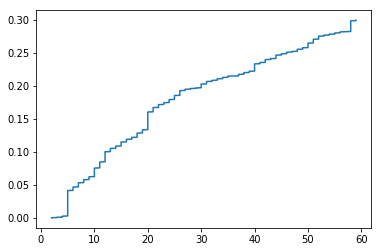

0.3
24.659803921568628
doubling


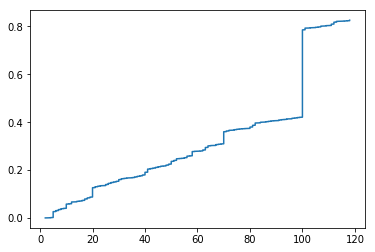

breaking in round 2
E(views): 561944.58 > target_views 100000.00
E(price): 59.57 > target_price 60.00


In [46]:
abc = explore(bids_explore, target_price, N, rounds=10, plot_win_fct=True)

In [47]:
for _ in range(10):
    s = exploit(abc, target_winrate, target_price, N, G)
    print(s)

(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)
(55.0, 55.0, nan, 166.57477854963795)


In [ ]:
sorted_data = np.sort(abc)
yvals=np.arange(len(abc))/float(len(abc)-1)
plt.plot(sorted_data,yvals)
plt.show()

In [ ]:
float(len(abc)-1)

In [ ]:
counts = pd.Series(sorted_data).value_counts(normalize=True, sort=False, dropna=False)
sorted_data=pd.DataFrame(sorted_data)

In [ ]:
sorted_data.columns = ['values']

In [ ]:

counts=pd.DataFrame(counts)
for_b_B = sorted_data.merge(counts, left_on='values', right_index=True)

In [ ]:
for_b_B.columns = ['vals', 'freq']

In [ ]:
abc = for_b_B

In [ ]:
abc